<img src="../imgs/Adevinta-ULPGC-logo.jpg" width="530px" align="right">

# **Modelos del lenguaje basados en redes neuronales artificiales**

## **Modelos seq2seq 1**

La arquitectura seq2seq, o secuencia a secuencia, es un tipo de modelo de red neuronal utilizado en el aprendizaje profundo para convertir secuencias de entrada en secuencias de salida. Es especialmente popular para tareas como traducción automática, generación de texto, y reconocimiento de voz. Se forma mediante la unión de dos componentes principales: un **codificador** y un **decodificador**.

<p align="center">
<img src="./imgs/seq2seq_.svg" width="80%">
</p>


#### **Codificador (Encoder)**

El codificador toma la secuencia de entrada y la procesa para generar una representación interna, a menudo en forma de un vector de contexto o una serie de estados ocultos. Aquí está el proceso detallado:

1. **Entrada de la secuencia**: El modelo toma una secuencia de entrada (por ejemplo, una frase en inglés si estamos haciendo traducción inglés-español).

2. **Embedding de palabras**: Cada palabra o token de la secuencia se transforma en un vector mediante una capa de embebido (embedding).

3. **Procesamiento recurrente**: Los vectores embebidos se pasan a través de capas recurrentes (como LSTM o GRU) para procesar la secuencia. En cada paso temporal, la red actualiza su estado oculto basándose en el token actual y el estado oculto anterior.

4. **Captura de contexto**: El último estado oculto de la red (o una combinación de todos los estados ocultos, dependiendo del diseño) se toma como la representación condensada de la secuencia completa. Este vector de contexto captura la información esencial de la entrada.

### **Decodificador (Decoder)**

El decodificador utiliza la representación generada por el codificador para producir la secuencia de salida.

1. **Inicialización**: El decodificador se inicializa con el estado oculto final del codificador. En algunos diseños, el vector de contexto también se usa directamente como parte de la entrada en cada paso del decodificador.

2. **Generación de la secuencia de salida**: En cada paso, el decodificador genera un token de la secuencia de salida.

   - **Estado oculto**: Se actualiza en cada paso basándose en la entrada actual y el estado oculto anterior.
   - **Entrada**: Puede ser el token de salida del paso anterior o un token especial para indicar el inicio de la secuencia.
   - **Salida**: Un vector que se transforma en las probabilidades de los diferentes tokens posibles para el siguiente paso de la secuencia. Esto se hace típicamente con una capa softmax.

3. **Terminación**: El proceso continúa hasta que se genera un token de final de secuencia o se alcanza una longitud máxima de secuencia.

### **Implementación**

Vamos a implementar un sencillo modelo seq2seq que realice la suma de dos números decimales de, como máximo, 3 cifras. La entrada será una cadena de texto con el formato "123+456" y la salida será una cadena de texto con el formato "0579".

#### **Dataset**

In [1]:
import random
import string
import torch

allowed_chars = string.digits + '+'

class Generator():
    def __init__(self) -> None:
        pass

    # Método para crear un ejemplo de entrenamiento
    def sample(self):
        s1 = random.randint(0, 999)
        s2 = random.randint(0, 999)
        r = s1 + s2
        s1_string = str(s1).zfill(4)
        s2_string = str(s2).zfill(4)
        output = str(r).zfill(4)
        input = s1_string + "+" + s2_string
        return input, output
    
    # Método para crear un lote de ejemplos de entrenamiento
    def batch(self, n):
        inputs = []
        outputs = []
        for _ in range(n):
            input, output = self.sample()
            inputs.append(input)
            outputs.append(output)
        return inputs, outputs
    
    # Método para codificar una cadena de caracteres en un tensor one-hot
    def string_to_tensor(self, s):
        tensor = torch.zeros(len(s), len(allowed_chars))
        for i, char in enumerate(s):
            tensor[i, allowed_chars.index(char)] = 1
        return tensor

    # Método para decodificar un tensor one-hot en una cadena de caracteres
    def tensor_to_string(self, tensor):
        _, max_idx = tensor.max(1)
        return ''.join([allowed_chars[i] for i in max_idx])
    
    # Método para generar un lote de ejemplos de entrenamiento codificados
    def batch_to_tensor(self, n):
        seq_in = []
        seq_out = []
        inputs, outputs = self.batch(n)
        for input, output in zip(inputs, outputs):
            seq_in.append(self.string_to_tensor(input))
            seq_out.append(self.string_to_tensor(output))
        return torch.stack(seq_in), torch.stack(seq_out)

#### **Modelo**

In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Definir la arquitectura del modelo seq2seq
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        _, (hn_enc, cn_enc) = self.encoder(input)
        latent_tensor = hn_enc[0].unsqueeze(1).repeat(1, 4, 1)  # Repeat 4 times for the output sequence length. Encoder hidden state is the latent tensor.
        out_dec, (_, _) = self.decoder(latent_tensor, (hn_enc, cn_enc))
        out = F.softmax(self.output(out_dec), dim=2)
        return out
    
model = Seq2Seq(input_size=len(allowed_chars), hidden_size=128, output_size=len(allowed_chars))

#### **Entrenamiento**

Epoch: 0, Loss: 0.08278626948595047
Epoch: 500, Loss: 0.04535852372646332
Epoch: 1000, Loss: 0.044752832502126694
Epoch: 1500, Loss: 0.04373709857463837
Epoch: 2000, Loss: 0.04096261039376259
Epoch: 2500, Loss: 0.03856367617845535
Epoch: 3000, Loss: 0.03128708153963089
Epoch: 3500, Loss: 0.02588800899684429
Epoch: 4000, Loss: 0.026218490675091743
Epoch: 4500, Loss: 0.025685178115963936
Epoch: 5000, Loss: 0.022701745852828026
Epoch: 5500, Loss: 0.02175910584628582
Epoch: 6000, Loss: 0.022094344720244408
Epoch: 6500, Loss: 0.02124878764152527
Epoch: 7000, Loss: 0.0180223286151886
Epoch: 7500, Loss: 0.014288426376879215
Epoch: 8000, Loss: 0.003746818518266082
Epoch: 8500, Loss: 0.0006115555297583342
Epoch: 9000, Loss: 0.0008122030412778258
Epoch: 9500, Loss: 0.00013642640260513872


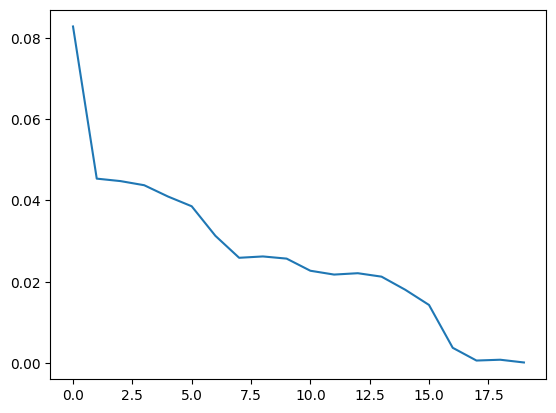

In [7]:
import matplotlib.pyplot as plt

history = []

# Bucle de entrenamiento
def train(model, optimizer, loss_fn, n_epochs, batch_size):
    for epoch in range(n_epochs):
        total_loss = 0
        
        optimizer.zero_grad()
        x, y = dg.batch_to_tensor(batch_size)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Print the loss every 10 epochs
        if epoch % 500 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss))
            history.append(total_loss)

# Definir la función de pérdida y el optimizador
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenar el modelo
dg = Generator()
train(model, optimizer, loss_fn, 10000, 128)


plt.plot(history, label='loss')

#### **Evaluación**

In [4]:
# Evaluar el modelo
def evaluate(model, n):
    x, y = dg.batch_to_tensor(n)
    y_pred = model(x)
    for i in range(n):
        print(dg.tensor_to_string(x[i]), dg.tensor_to_string(y_pred[i]), dg.tensor_to_string(y[i]))

evaluate(model, 10)

0828+0598 1423 1426
0100+0894 0996 0994
0077+0596 0670 0673
0449+0372 0820 0821
0616+0335 0954 0951
0383+0077 0469 0460
0251+0693 0944 0944
0087+0201 0286 0288
0271+0604 0876 0875
0885+0774 1668 1659


Es importante destacar que el modelo no realiza una suma de números siguiendo un procedimiento aritmético, sino que aprende a generar la secuencia de salida correcta mediante un proceso de traducción aprendido a partir de los datos de entrenamiento.

---

### Ejercicio 1

Modifica el modelo seq2seq anterior para que acepte cualquier longitud de sumandos y resultados. Fíjate en la línea 17:

`latent_tensor = hn_enc[0].unsqueeze(1).repeat(1, 4, 1)  # Repeat 4 times for the output sequence length. Encoder hidden state is the latent tensor.`

El número 4 indica la longitud de la secuencia de salida. Modifica este número para que se ajuste a la longitud máxima de la secuencia de salida.

### Ejercicio 2

Tenemos un dataset que contiene pares de secuencias de texto, donde la primera secuencia es un número entero en notación decimal y la segunda secuencia es el número en texto en inglés. Por ejemplo:

372409679, "three hundred seventy two million four hundred nine thousand six hundred seventy nine"

Crea un modelo seq2seq que traduzca números enteros en notación decimal a texto en inglés. El modelo debe ser capaz de traducir números de hasta 9 cifras.

A continuación se proporciona el código para cargar el dataset, crear el vocabulario y preparar el DataLoader.

---

<div style="background-color:#e3fcff; padding: 15px; box-shadow: 0px 0px 10px rgba(0,0,0,0.2);">

##### **Nota**

Consulta la documentación de la clase `Dataset`de PyTorch en el siguiente enlace: [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

Esta clase es una clase abstracta que representa un conjunto de datos. Su función principal es implementar dos métodos: `__len__` y `__getitem__`.

</div>

In [5]:
# Clase para generar ejemplos de entrenamiento a partir de las clases que provee Torchtext
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import vocab
from collections import Counter, OrderedDict


class NumbersAndText(Dataset):
    def __init__(self, file):
        self.file = file
        with open(file, 'r') as f:
            self.data = f.readlines()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        line = self.data[idx].split(", ")
        label = line[1][1:-3].split()
        words = line[0]
        return words, label
    
    
def create_vocab(file):
    with open(file, 'r') as f:
        data = f.readlines()
        tokens = []
        for line in data:
            line = line.split(", ")
            label = line[1][1:-3]
            words = label.split()
            tokens.extend(words)

        counter = Counter(tokens)
        sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        ordered_dict = OrderedDict(sorted_by_freq_tuples)
        v = vocab(ordered_dict)
        return v

    
    
voc = create_vocab('data/numbers.txt')
print(voc.get_itos())
print(voc.get_stoi())
print(voc['one'])
print(len(voc))

ds = NumbersAndText('data/numbers.txt')
print(ds[0])
print("-------------------")
data_loader = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=lambda x: x)
L = next(iter(data_loader))
for i in L:
    print(i)

['hundred', 'million', 'thousand', 'six', 'eight', 'three', 'seven', 'one', 'four', 'nine', 'five', 'two', 'twenty', 'ninety', 'thirty', 'forty', 'eighty', 'seventy', 'fifty', 'sixty', 'seventeen', 'fourteen', 'nineteen', 'sixteen', 'thirteen', 'twelve', 'fifteen', 'eighteen', 'ten', 'eleven']
{'eleven': 29, 'eighteen': 27, 'fifteen': 26, 'ninety': 13, 'nineteen': 22, 'fourteen': 21, 'seventeen': 20, 'fifty': 18, 'seventy': 17, 'two': 11, 'thousand': 2, 'four': 8, 'thirteen': 24, 'hundred': 0, 'one': 7, 'seven': 6, 'ten': 28, 'nine': 9, 'three': 5, 'sixteen': 23, 'thirty': 14, 'six': 3, 'twelve': 25, 'million': 1, 'sixty': 19, 'twenty': 12, 'eight': 4, 'five': 10, 'eighty': 16, 'forty': 15}
7
30
('372409679', ['three', 'hundred', 'seventy', 'two', 'million', 'four', 'hundred', 'nine', 'thousand', 'six', 'hundred', 'seventy', 'nine'])
-------------------
('947607438', ['nine', 'hundred', 'forty', 'seven', 'million', 'six', 'hundred', 'seven', 'thousand', 'four', 'hundred', 'thirty', 'ei